# Setup

## Library import

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as et
import os
import re
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from ktrain import text
import ktrain
from transformers import AutoTokenizer, AutoModelForMaskedLM
  
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [27]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [28]:
import emoji

## Setup variables

In [2]:
data_dir = "data"

In [3]:
training_data_dir = os.path.join(data_dir, "training")

In [24]:
hashtag_analyzed = "#debateTelemadrid"

# Data import and processing

## Training data extraction and concatenation

In [4]:
rows = []

Our datasets with tweets labeled with sentiment come in XML format. We extract the tweet text and polarity for every year's dataset.

In [6]:
tass_2012_train_root = et.parse(os.path.join(training_data_dir, "2012_train-tagged.xml")).getroot()
for node in tass_2012_train_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiments").find("polarity").find("value").text
    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)
    

In [7]:
tass_2012_test_root = et.parse(os.path.join(training_data_dir, "2012_test-tagged.xml")).getroot()
for node in tass_2012_test_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiments").find("polarity").find("value").text
    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)

In [8]:
tass_2013_test_root = et.parse(os.path.join(training_data_dir, "2013_politics-test-tagged.xml")).getroot()
for node in tass_2013_test_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiments").find("polarity").find("value").text

    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)

In [9]:
tass_2018_train_root = et.parse(os.path.join(training_data_dir, "2018_train-tagged.xml")).getroot()
for node in tass_2018_train_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiment").find("polarity").find("value").text

    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)

In [10]:
tass_2018_test_root = et.parse(os.path.join(training_data_dir, "2018_test-tagged.xml")).getroot()
for node in tass_2018_test_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiment").find("polarity").find("value").text

    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)

In [11]:
tass_2019_train_root = et.parse(os.path.join(training_data_dir, "2019_train-tagged.xml")).getroot()
for node in tass_2019_train_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiment").find("polarity").find("value").text
    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)
    

In [12]:
tass_2019_test_root = et.parse(os.path.join(training_data_dir, "2019_test-tagged.xml")).getroot()
for node in tass_2019_test_root:
    tweet = node.find("content").text
    sentiment = node.find("sentiment").find("polarity").find("value").text
    if sentiment == "N":
        sentiment = "NEG"
    elif sentiment == "P":
        sentiment = "POS"
    else:
        sentiment = "NEU"
    row = {"text":tweet, "sentiment": sentiment}
    rows.append(row)
    

In [13]:
training_tweets = pd.DataFrame(rows)

This other dataset comes labeled by multiple people with various adjectives. Since we only care about the sentiment, we assign the sentiment which most people voted for.

In [14]:
mas_corpus_all = pd.read_excel(os.path.join(training_data_dir, "mascorpus.xls"), sheet_name="FINAL", header=1)
keep_cols = ['TEXTO', 'ODIO', 'TRISTEZA', 'TEMOR',
       'INSATISFACCION', 'NC2.2', 'SATISFACCION', 'CONFIANZA', 'FELICIDAD',
       'AMOR', 'ODIO.1', 'TRISTEZA.1', 'TEMOR.1', 'INSATISFACCION.1', 'NC2.3',
       'SATISFACCION.1', 'CONFIANZA.1', 'FELICIDAD.1', 'AMOR.1', 'ODIO.2',
       'TRISTEZA.2', 'TEMOR.2', 'INSATISFACCION.2', 'NC2.4', 'SATISFACCION.2',
       'CONFIANZA.2', 'FELICIDAD.2', 'AMOR.2']
mas_corpus = mas_corpus_all[keep_cols]

In [15]:
mas_corpus_summarized = mas_corpus.copy()
for i in range(1, 10):
    col_nums = range(i, i+19, 9)
    columns = mas_corpus_summarized[[mas_corpus_summarized.columns[i] for i in col_nums]]
    mas_corpus_summarized.iloc[:,i] = columns.sum(axis=1)

mas_corpus_summarized = mas_corpus_summarized.iloc[:, :10]

In [16]:
mas_corpus_collapsed = mas_corpus_summarized.copy()
mas_corpus_collapsed["POS"] = mas_corpus_collapsed[["SATISFACCION", "CONFIANZA", "FELICIDAD", "AMOR"]].sum(axis=1)
mas_corpus_collapsed["NEG"] = mas_corpus_collapsed[["ODIO", "TRISTEZA", "TEMOR", "INSATISFACCION"]].sum(axis=1)
mas_corpus_collapsed["NEU"] = mas_corpus_collapsed[["NC2.2"]]
mas_corpus_collapsed = mas_corpus_collapsed[["TEXTO", "POS", "NEU", "NEG"]]
mas_corpus_collapsed

,TEXTO,POS,NEU,NEG
0,#tablondeanuncios Funda nordica ikea #madrid h...,0.0,1,0
1,#tr Me ofrezco para montar muebles de Ikea - H...,0.0,1,0
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,0.0,1,0
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,0.0,1,0
4,$Carrefour retira pez #Panga. OCU y grupos x #...,0.0,1,0
...,...,...,...,...
3758,#or Me ofrezco para montar muebles de Ikea - H...,0.0,1,0
3759,#Policiales || Crimen en el Carrefour: las cám...,0.0,1,0
3760,#PrayFor @nestorpower que se ha quedado sin la...,1.0,0,0
3761,#rv Me ofrezco para montar muebles de Ikea - H...,0.0,1,0


In [17]:
mas_corpus_collapsed["sentiment"]=np.where(
    np.logical_and((mas_corpus_collapsed["POS"] > mas_corpus_collapsed ["NEU"]),  (mas_corpus_collapsed["POS"] > mas_corpus_collapsed ["NEG"])), "POS",
    np.where(np.logical_and((mas_corpus_collapsed["NEU"] > mas_corpus_collapsed ["POS"]),  (mas_corpus_collapsed["NEU"] > mas_corpus_collapsed ["NEG"])), "NEU", "NEG"
    )
)
mas_corpus_collapsed["sentiment"].value_counts()

NEU    2426
POS     743
NEG     594
Name: sentiment, dtype: int64

In [18]:
mas_corpus_final = mas_corpus_collapsed[["TEXTO", "sentiment"]].rename(columns={"TEXTO":"text"})

In [19]:
training_tweets = pd.concat([mas_corpus_final, training_tweets], ignore_index=True)

In [20]:
training_tweets

,text,sentiment
0,#tablondeanuncios Funda nordica ikea #madrid h...,NEU
1,#tr Me ofrezco para montar muebles de Ikea - H...,NEU
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,NEU
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,NEU
4,$Carrefour retira pez #Panga. OCU y grupos x #...,NEU
...,...,...
77495,@Davorias Pero es que está muy rica,POS
77496,@narvalillo Eso es antiguo ya,NEG
77497,Mi TL esta vacía a estas horas,NEG
77498,"Ya tengo uno, pero ese es más cheto @aweamasome.",NEU


In [21]:
training_tweets.to_csv(os.path.join(training_data_dir, "training_tweets.csv"))

## Import and join election tweets

In [22]:
training_df = pd.read_csv(os.path.join(training_data_dir, "training_tweets.csv")).iloc[:, 1:]

In [23]:
training_df

,text,sentiment
0,#tablondeanuncios Funda nordica ikea #madrid h...,NEU
1,#tr Me ofrezco para montar muebles de Ikea - H...,NEU
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,NEU
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,NEU
4,$Carrefour retira pez #Panga. OCU y grupos x #...,NEU
...,...,...
77495,@Davorias Pero es que está muy rica,POS
77496,@narvalillo Eso es antiguo ya,NEG
77497,Mi TL esta vacía a estas horas,NEG
77498,"Ya tengo uno, pero ese es más cheto @aweamasome.",NEU


Our tweets dataset was saved as 5 separate csv files which we import and concatenate here.

In [25]:
election_tweets = pd.read_json(os.path.join(data_dir, hashtag_analyzed + ".json"))

In [26]:

election_tweets

,name,tweet,retweets,created,followers,is_user_verified,favorite_count,favorited,retweeted
0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False
1,Apis2576,#Iglesias y #Redondo pactaron reventar la camp...,1,"04/27/2021, 14:46:43",2132,False,0,False,False
2,GoyoLafarge,Si llego a mil seguidores antes de las elecion...,1,"04/27/2021, 12:59:12",645,False,0,False,False
3,adsuara,Aparezco (mi cuenta de Twitter) en el Grafo de...,4,"04/27/2021, 11:01:38",23970,False,35,False,False
4,roscullell,@EMesembria @Monica_Garcia_G Es anestesista y ...,0,"04/27/2021, 10:26:38",7312,False,1,False,False
...,...,...,...,...,...,...,...,...,...
39538,maestra3000,@Macarena_Olona #novotesalquetebote la tropa y...,6,"04/20/2021, 14:01:35",504,False,6,False,False
39539,akyyo,Te están llamando gallina @IdiazAyuso \n#Debat...,0,"04/20/2021, 13:57:21",111,False,0,False,False
39540,telemadrid,A continuación os contamos todos los preparati...,2,"04/20/2021, 10:09:04",115845,True,0,False,False
39541,FeSorCam,"#DebateTelemadrid día 21, tras el Telenoticias...",2,"04/20/2021, 08:57:53",2377,False,4,False,False


We replace newline characters (\\n), non-letters and urls with spaces, and replace any length of jajaja, hahaha, jejeje with a single "jajaja".

In [29]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number', 'hashtag'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=False,  # perform word segmentation on hashtags
    unpack_contractions=False,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /Users/inigo/.ekphrasis/stats/twitter/counts_1grams.txt
You can't omit/backoff and unpack hashtags!
 unpack_hashtags will be set to False


In [30]:
def process_text(raw_text):
    no_emojis = emoji.demojize(str(raw_text), delimiters=("<", ">"))
    no_newlines = re.sub("\\n", " ", no_emojis)
    social_processed = " ".join(text_processor.pre_process_doc(no_newlines))
    letters_only = re.sub("([HhJj][A-zÀ-ú]){2,}[HhJj]*", "jajaja", str(social_processed))
    words = letters_only.lower().split()
    return (" ".join(words))

In [31]:
training_df['clean_text'] = training_df['text'].apply(lambda x: process_text(x))

In [32]:
training_df

,text,sentiment,clean_text
0,#tablondeanuncios Funda nordica ikea #madrid h...,NEU,<hashtag> funda nordica ikea <hashtag> <url> <...
1,#tr Me ofrezco para montar muebles de Ikea - H...,NEU,<hashtag> me ofrezco para montar muebles de ik...
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,NEU,<hashtag> vozpópuli <user> - <hashtag> mercado...
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,NEU,<hashtag> destacado : todo lo que hay que sabe...
4,$Carrefour retira pez #Panga. OCU y grupos x #...,NEU,$ carrefour retira pez <hashtag> . ocu y grupo...
...,...,...,...
77495,@Davorias Pero es que está muy rica,POS,<user> pero es que está muy rica
77496,@narvalillo Eso es antiguo ya,NEG,<user> eso es antiguo ya
77497,Mi TL esta vacía a estas horas,NEG,mi tl esta vacía a estas horas
77498,"Ya tengo uno, pero ese es más cheto @aweamasome.",NEU,"ya tengo uno , pero ese es más cheto <user> ."


In [33]:
election_tweets['clean_text'] = election_tweets['tweet'].apply(lambda x: process_text(x))

In [34]:
election_tweets[["tweet", "clean_text"]]

,tweet,clean_text
0,Lo de las amenazas al gobierno progresista de ...,lo de las amenazas al gobierno progresista de ...
1,#Iglesias y #Redondo pactaron reventar la camp...,<hashtag> y <hashtag> pactaron reventar la cam...
2,Si llego a mil seguidores antes de las elecion...,si llego a mil seguidores antes de las elecion...
3,Aparezco (mi cuenta de Twitter) en el Grafo de...,aparezco ( mi cuenta de twitter ) en el grafo ...
4,@EMesembria @Monica_Garcia_G Es anestesista y ...,<user> <user> es anestesista y tiene dos jajaj...
...,...,...
39538,@Macarena_Olona #novotesalquetebote la tropa y...,<user> <hashtag> la tropa y marinería votamos ...
39539,Te están llamando gallina @IdiazAyuso \n#Debat...,te están llamando gallina <user> <hashtag> <ha...
39540,A continuación os contamos todos los preparati...,a continuación os contamos todos los preparati...
39541,"#DebateTelemadrid día 21, tras el Telenoticias...","<hashtag> día <number> , tras el telenoticias ..."


## Prepare data for training

We prepare the data for training:
We split the labeled data into train and test, making sure to stratify by the labels to ensure a similar distribution of labels between test and train.

In [35]:
texts = training_df["clean_text"].fillna("fillna").values
labels = training_df["sentiment"].values
x_train, x_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=42, stratify=labels)
x_pred =  election_tweets["clean_text"].fillna("fillna").values


We download a huggingface model pre-trained on the spanish Wikipedia corpus: https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased#:~:text=dccuchile%2Fbert%2Dbase%2Dspanish,%2Dwwm%2Duncased%20%C2%B7%20Hugging%20Face

In [36]:
t = text.Transformer("dccuchile/bert-base-spanish-wwm-uncased", class_names=list(set(labels)))
model = t.get_classifier()

/Users/inigo/miniconda3/envs/nlp-test/lib/python3.6/site-packages/ktrain/text/preprocessor.py:423: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn('The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.')


We preprocess the data to get it into the format BERT expects: padded and with special characters at the beginning and end.

In [37]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
pred = t.preprocess_test(x_pred)

preprocessing train...
language: es
train sequence lengths:
	mean : 20
	95percentile : 31
	99percentile : 34


/Users/inigo/miniconda3/envs/nlp-test/lib/python3.6/site-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Exception ignored in: <bound method tqdm.__del__ of <tqdm.auto.tqdm object at 0x7f860c83a2e8>>
Traceback (most recent call last):
  File "/Users/inigo/miniconda3/envs/nlp-test/lib/python3.6/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/inigo/miniconda3/envs/nlp-test/lib/python3.6/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Is Multi-Label? False
preprocessing test...
language: es
test sequence lengths:
	mean : 20
	95percentile : 31
	99percentile : 35


preprocessing test...
language: es
test sequence lengths:
	mean : 24
	95percentile : 49
	99percentile : 56


# Model Training

If not re-training model skip to next section (Prediction)

In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

We select a learning rate halfway down the steepest part of the loss-curve slope.

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
2137/2137 [==============================] - 372s 163ms/step - loss: 2.4783 - accuracy: 0.4493


done.
Visually inspect loss plot and select learning rate associated with falling loss


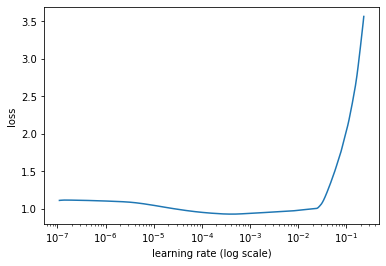

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
learner.autofit(5e-5, checkpoint_folder="model_checkpoints")

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
2180/2180 [==============================] - 1773s 802ms/step - loss: 0.7521 - accuracy: 0.6559 - val_loss: 0.5712 - val_accuracy: 0.7533
Epoch 2/1024
2180/2180 [==============================] - 1764s 803ms/step - loss: 0.5060 - accuracy: 0.7898 - val_loss: 0.5611 - val_accuracy: 0.7605
Epoch 3/1024
2180/2180 [==============================] - 1764s 803ms/step - loss: 0.3832 - accuracy: 0.8477 - val_loss: 0.6103 - val_accuracy: 0.7609
Epoch 4/1024
2180/2180 [==============================] - 1765s 803ms/step - loss: 0.2594 - accuracy: 0.9032 - val_loss: 0.6941 - val_accuracy: 0.7546

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 5/1024
2180/2180 [==============================] - 1764s 803ms/step - loss: 0.1566 - accuracy: 0.9455 - val_los

Although training accuracy increased to 97%, validation accuracy remained at 74%, indicating the network was overfitting in further epochs.

In [ ]:
learner.model.save_pretrained("saved_model")

Since Colab limits the use of GPUs and we can suddenly be disconnected from the runtime we make sure to save the network's weights when we are done training it.

# Predictions

We can use this line of code to import the transformer we saved above.

In [38]:
t=text.Transformer("saved_model", class_names=list(set(labels)))

In [39]:
model = t.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

In [ ]:
predictions = learner.predict(val_data=pred)

In [ ]:
predictions

array([[0.62190163, 0.28655723, 0.09154113],
       [0.81316984, 0.1755967 , 0.01123353],
       [0.01346189, 0.07407705, 0.9124611 ],
       ...,
       [0.00968208, 0.8043853 , 0.18593256],
       [0.01846363, 0.12628841, 0.855248  ],
       [0.01757779, 0.910417  , 0.07200523]], dtype=float32)

The predictions are returned as class probabilities. We assign the class with the largest predicted probability, although depending on our business requirements we might want to require a greater confidence to assign a positive or a negative label.

In [ ]:
predictions=pd.DataFrame(predictions, columns=list(set(labels)))

In [ ]:
election_tweets_pred = election_tweets.copy()

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
election_tweets_pred["sentiment"] = np.where(
    np.logical_and(predictions["NEG"] > predictions["NEU"], predictions["NEG"] > predictions["POS"]),
    "NEG", 
    np.where(
        np.logical_and(predictions["NEU"] > predictions["NEG"], predictions["NEU"] > predictions["POS"]),
        "NEU", 
        "POS")
    
)

In [ ]:
election_tweets_pred[["tweet","sentiment"]].sample(20)

,tweet,sentiment
14438,Pereza! \n#DebateTelemadrid,POS
11397,#DebateTelemadrid el milagro económico es no tener que dar una paguita de 700€ a los autónomos para que puedan malvivir.,NEU
21665,"Ayuso es muy cristiana. Hasta se saltó una Conferencia de Presidentes para ponerse el outfit de beata y ponerse a llorar, curiosamente delante de unas cámaras que pasaban por allí. #DebateTelemadrid",NEG
28819,Ver al coletas dando lecciones desde su chalet y la gente aun creyendo en el partido demuestra que en este país vale todo 🤣🤣🤣🤣🤣🤣#DebateTelemadrid,NEU
9042,"Jajajajajajaja Iglesias diciendo que hay que dimitir para presentarse a unas elecciones jajaja\n\nHabrá que recordarle que él no dimitió, él fue cesado por Sánchez para cobrar la indemnización.\n\nJeta es poco.\n#DebateTelemadrid",NEG
13168,🔵 La única opción solvente para gobernar la Comunidad de Madrid es Isabel Díaz Ayuso.\n\nEstá desmontando uno a uno los mantras y las mentiras de la izquierda.\n\n@anacamins\n \n#DebateTelemadrid \n#YoConAyuso https://t.co/hEgrtcycVL,NEG
22610,#DebateTelemadrid\nEl candidato de podemos/as/es\nDiciendo que dentista gratis.\nYa está pensado en cómo ahorrar dinero,NEU
9702,Interesante. 👇👇\n\n#DebateTelemadrid https://t.co/MDDujZ3fKq,NEU
21692,Ojo que Gabilondo se anima #DebateTelemadrid https://t.co/3sJjVpUFQ9,NEU
37760,"Ufffff este moderador no me gusta.\nQue se calle el hombre, dejen hablar a Maria Rey.\n#DebateTelemadrid",NEG


In [ ]:
election_tweets_pred.to_csv(os.path.join(data_dir, "predictions.csv"))

In [ ]:
pd.set_option('display.max_colwidth', 50)

# Processing

In this section we extract hashtags and whether each candidate was mentioned in a tweet.

In [ ]:
election_tweets_pred = pd.read_csv(os.path.join(data_dir, "predictions.csv"))

In [ ]:
mystringlist = election_tweets_pred['tweet']
mystringlist.head()

0    Lo de las amenazas al gobi...
1    #Iglesias y #Redondo pacta...
2    Si llego a mil seguidores ...
3    Aparezco (mi cuenta de Twi...
4    @EMesembria @Monica_Garcia...
Name: tweet, dtype: object

In [ ]:
def hashtags(tweet):
 return list(filter(lambda token: token.startswith('#'), tweet.split()))

list_hashtags= [hashtags(string) for string in mystringlist]
df_list = pd.DataFrame([list_hashtags])

print (df_list)

                           0      ...                          39538
0  [#DebateTelemadrid, #LosDe...  ...  [#DebateTelemadrid, #elecc...

[1 rows x 39539 columns]


In [ ]:
df_list=df_list.T
df_list.columns =['hashtag']
df_list.head()

,hashtag
0,"[#DebateTelemadrid, #LosDe..."
1,"[#Iglesias, #Redondo, #Deb..."
2,"[#Ayuso, #SiguemeYTeSigo, ..."
3,"[#DebateTelemadrid,]"
4,[#DebateTelemadrid]


In [ ]:
exploded_df = df_list.explode('hashtag')
exploded_df['counted'] =1
exploded_df.head()

,hashtag,counted
0,#DebateTelemadrid,1
0,#LosDemocratasSomosMas,1
0,#LaIzquierdaGana,1
1,#Iglesias,1
1,#Redondo,1


In [ ]:
merged_inner = pd.merge(left=election_tweets_pred, right=exploded_df, left_index=True, right_index=True)
merged_inner.head()


,Unnamed: 0,name,tweet,retweets,created,followers,is_user_verified,favorite_count,favorited,retweeted,sa_es,clean_text,sentiment,hashtag,counted
0,0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False,NEG,lo de las amenazas al gobierno progresista de ...,NEG,#DebateTelemadrid,1
0,0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False,NEG,lo de las amenazas al gobierno progresista de ...,NEG,#LosDemocratasSomosMas,1
0,0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False,NEG,lo de las amenazas al gobierno progresista de ...,NEG,#LaIzquierdaGana,1
1,1,Apis2576,#Iglesias y #Redondo pactaron reventar la camp...,1,"04/27/2021, 14:46:43",2132,False,0,False,False,NEG,iglesias y redondo pactaron reventar la campañ...,NEG,#Iglesias,1
1,1,Apis2576,#Iglesias y #Redondo pactaron reventar la camp...,1,"04/27/2021, 14:46:43",2132,False,0,False,False,NEG,iglesias y redondo pactaron reventar la campañ...,NEG,#Redondo,1


In [ ]:
table = merged_inner.copy()

We are returning 1 for each candidate's column if one of the terms is found.

In [ ]:
table['Ayuso'] = np.where(table['tweet'].str.contains(('Ayuso|pp|Partido Popular'), case=False), 1,0)
table['Mónica_García'] = np.where(table['tweet'].str.contains(('Monica|Mónica|García|Garcia|Más Madrid|Mas Madrid|masmadrid|másmadrid'), case=False), 1,0)
table['Ángel_Gabilondo'] = np.where(table['tweet'].str.contains(('Gabilondo|PSOE|Ángel|Angel|partido socialista'), case=False), 1,0)
table['Pablo_Iglesias'] = np.where(table['tweet'].str.contains(('Pablo|Iglesias|Unidas Podemos|unidos podemos|Podemos'), case=False), 1,0)
table['Edmundo_Bal'] = np.where(table['tweet'].str.contains(('Edmundo Bal|BalEdmundo|CiudadanosCs'), case=False), 1,0)
table['Rocío_Monasterio'] = np.where(table['tweet'].str.contains(('Rocío|Rocio|Monasterio|VOX'), case=False), 1,0)



table.head()

,Unnamed: 0,name,tweet,retweets,created,followers,is_user_verified,favorite_count,favorited,retweeted,sa_es,clean_text,sentiment,hashtag,counted,Ayuso,Mónica_García,Ángel_Gabilondo,Pablo_Iglesias,Edmundo_Bal,Rocío_Monasterio
0,0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False,NEG,lo de las amenazas al gobierno progresista de ...,NEG,#DebateTelemadrid,1,0,0,1,1,0,0
0,0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False,NEG,lo de las amenazas al gobierno progresista de ...,NEG,#LosDemocratasSomosMas,1,0,0,1,1,0,0
0,0,Jhernandogarcia,Lo de las amenazas al gobierno progresista de ...,1,"04/27/2021, 15:32:49",1912,False,1,False,False,NEG,lo de las amenazas al gobierno progresista de ...,NEG,#LaIzquierdaGana,1,0,0,1,1,0,0
1,1,Apis2576,#Iglesias y #Redondo pactaron reventar la camp...,1,"04/27/2021, 14:46:43",2132,False,0,False,False,NEG,iglesias y redondo pactaron reventar la campañ...,NEG,#Iglesias,1,0,0,0,1,0,0
1,1,Apis2576,#Iglesias y #Redondo pactaron reventar la camp...,1,"04/27/2021, 14:46:43",2132,False,0,False,False,NEG,iglesias y redondo pactaron reventar la campañ...,NEG,#Redondo,1,0,0,0,1,0,0


In [ ]:
table.drop("clean_text", axis=1).to_excel("predictions_and_mentions.xlsx")

In [18]:
candidate_counts = table.loc[:,"Ayuso":].sum(axis=1).value_counts(normalize=True).sort_index()

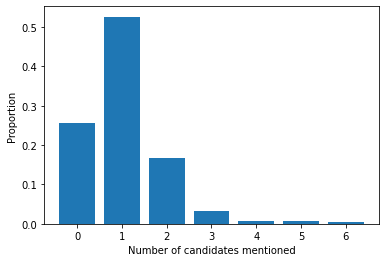

In [22]:
plt.bar(candidate_counts.index, candidate_counts)
plt.xlabel("Number of candidates mentioned")
plt.ylabel("Proportion");

In [25]:
1-candidate_counts[0:2].sum()

0.21709958472437096